In [2]:
%matplotlib inline

In [3]:

import os
import numpy as np
import json
from ipywidgets import interact
import matplotlib.pyplot as plt
import torch
import random
import re
from tqdm.auto import tqdm
from espnet.asr.pytorch_backend.asr import load_trained_model
if 'cd' not in globals():
    cd = True
    os.chdir('..')
# import matplotlib
# matplotlib.use('TkAgg')

In [4]:

i = 16
model, train_args = load_trained_model(f'exp/train_pytorch_wav2vecfexlembvq/results/snapshot.ep.{i}')
device = torch.device('cuda')
model = model.float()
model = model.to(device)



In [5]:
# code = model.quantizer.codebook().detach().cpu().numpy()

In [5]:
code = model.quantizer.vars.squeeze()[:320].detach().cpu().numpy()
code.shape

(320, 256)

In [30]:
from sklearn.manifold import TSNE 
from sklearn.decomposition import PCA
# tsne = TSNE(n_components=2, init='pca' , random_state=0, perplexity=30)
tsne = PCA(n_components=2, random_state=0,)
embs = tsne.fit_transform(code)

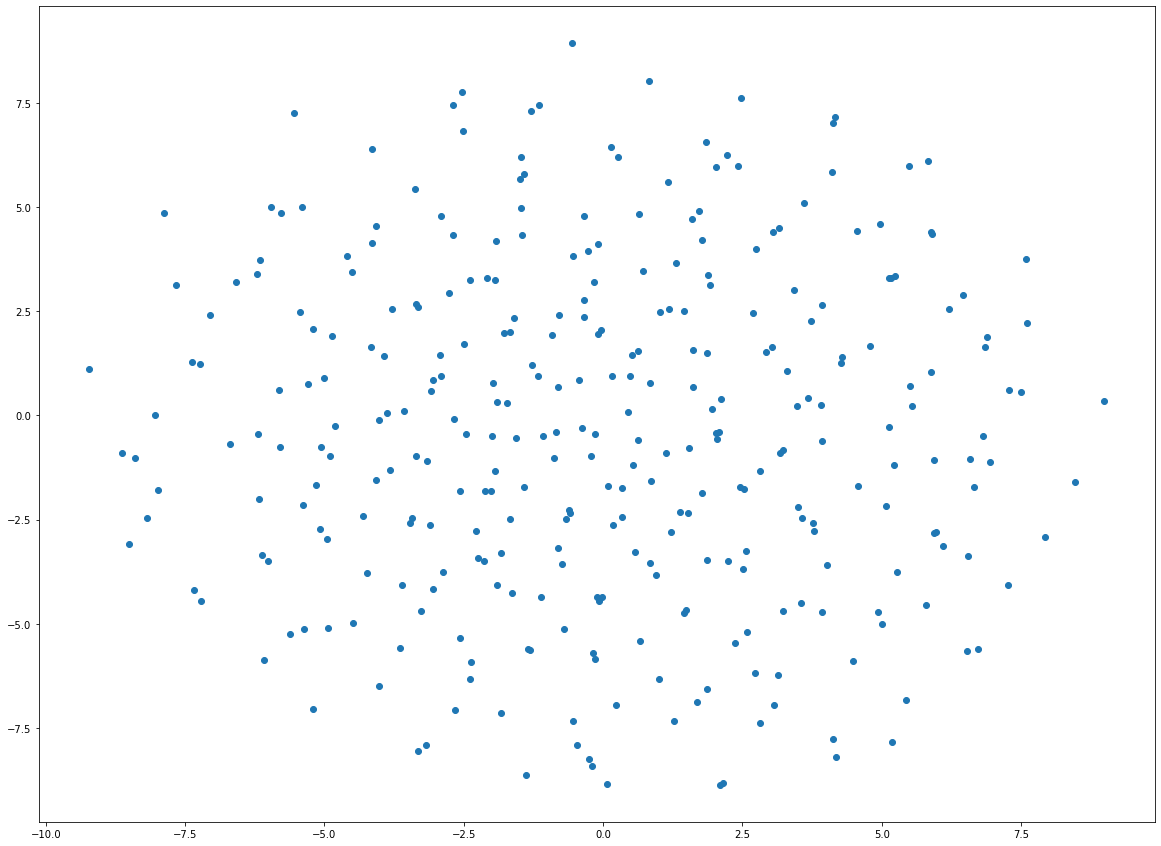

In [25]:
plt.figure(figsize=(20,15))
plt.scatter(embs[:,0], embs[:,1])
plt.savefig('code')

In [31]:
code = model.quantizer.vars.squeeze()[320:].detach().cpu().numpy()
code.shape

(320, 256)

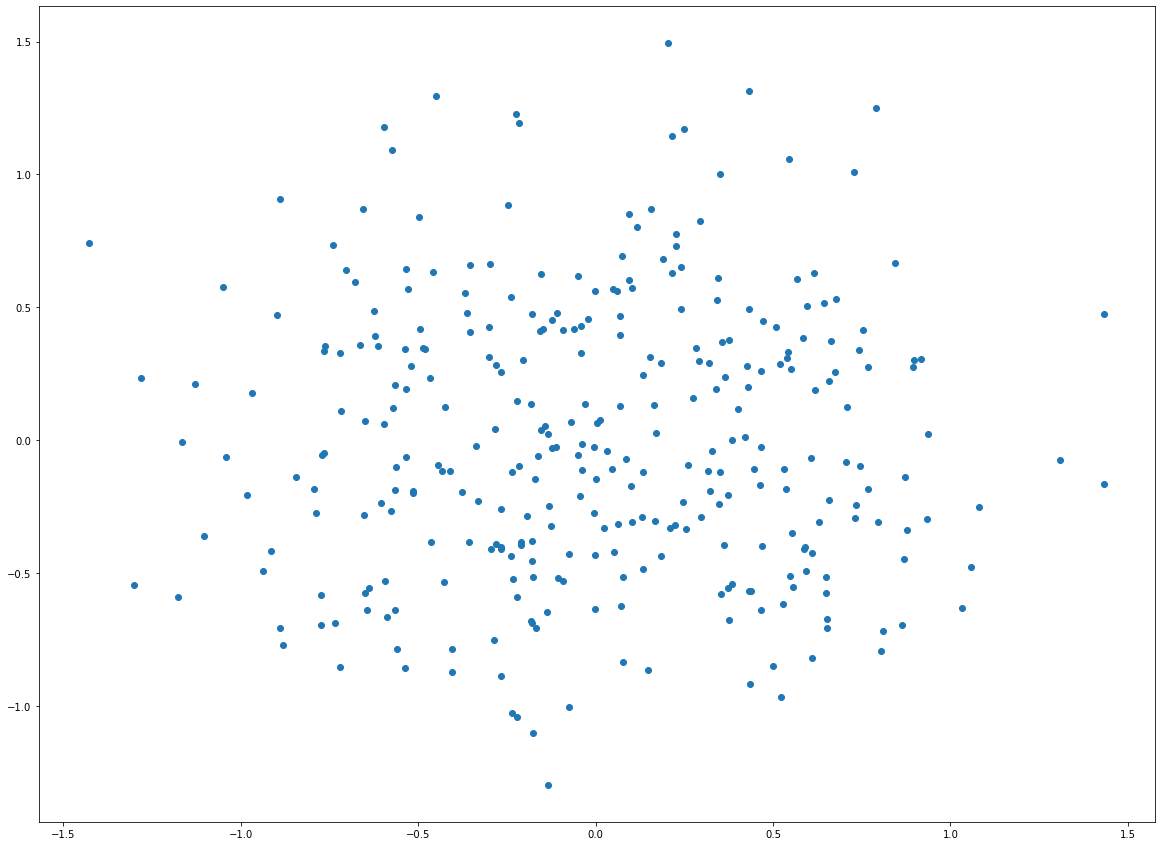

In [32]:
from sklearn.manifold import TSNE 
from sklearn.decomposition import PCA
# tsne = TSNE(n_components=2, init='pca' , random_state=0, perplexity=30)
tsne = PCA(n_components=2, random_state=0,)
embs = tsne.fit_transform(code)
plt.figure(figsize=(20,15))
plt.scatter(embs[:,0], embs[:,1])
plt.savefig('code')

In [6]:
from fairseq.modules import KmeansVectorQuantizer

In [ ]:
model()

In [9]:
x = torch.randn(2, 111,  512)

In [8]:
kmq = KmeansVectorQuantizer(dim=512, num_vars=320, groups=2, combine_groups=False, vq_dim=512, time_first=True)

In [10]:
kmq(x)

{'num_vars': 320,
 'code_perplexity': tensor(252.7024),
 'x': tensor([[[-0.0064, -0.0026,  0.0039,  ..., -0.0051, -0.0040,  0.0193],
          [ 0.0010,  0.0056, -0.0208,  ...,  0.0019,  0.0114, -0.0115],
          [ 0.0119, -0.0082,  0.0112,  ..., -0.0109,  0.0026, -0.0093],
          ...,
          [-0.0038,  0.0119,  0.0047,  ...,  0.0095,  0.0091, -0.0078],
          [-0.0130,  0.0035,  0.0020,  ...,  0.0087, -0.0081,  0.0073],
          [-0.0061, -0.0233,  0.0004,  ...,  0.0075,  0.0235,  0.0030]],
 
         [[-0.0065, -0.0087,  0.0074,  ..., -0.0138, -0.0092,  0.0094],
          [-0.0063, -0.0064,  0.0159,  ...,  0.0071, -0.0126,  0.0026],
          [ 0.0101,  0.0055, -0.0054,  ...,  0.0011,  0.0055, -0.0153],
          ...,
          [ 0.0277, -0.0009, -0.0099,  ..., -0.0108,  0.0012, -0.0096],
          [-0.0159, -0.0013, -0.0184,  ..., -0.0030,  0.0029,  0.0008],
          [ 0.0043,  0.0098, -0.0025,  ..., -0.0062,  0.0142,  0.0102]]],
        grad_fn=<TransposeBackward0>),
 

In [34]:
model.quantizer.get_codebook_indices().view(-1, 2).size(0)

102400

In [36]:
model.quantizer.sample_from_codebook(2,5).size()

torch.Size([2, 5, 512])

In [37]:
model.quantizer.weight_proj

Linear(in_features=512, out_features=640, bias=True)

In [38]:
model.quantizer.num_vars

320

In [7]:
bsz, tsz, fsz = x.shape

In [8]:
self = model.quantizer

In [9]:
x = x.reshape(-1, fsz) # (bsz x tsz), fsz
x = self.weight_proj(x) # (bsz x tsz), (num_vars x groups)
x = x.view(bsz * tsz * self.groups, -1) # (bsz x tsz x groups), (num_vars)

In [10]:
x.size()

torch.Size([444, 320])

In [11]:
result = {}
_, k = x.max(-1) # bsz, tsz, groups
hard_x = (
    x.new_zeros(*x.shape)
    .scatter_(-1, k.view(-1, 1), 1.0)
    .view(bsz * tsz, self.groups, -1)
) # (bsz x tsz), groups, num_vars
hard_probs = torch.mean(hard_x.float(), dim=0)
result["code_perplexity"] = torch.exp(
    -torch.sum(hard_probs * torch.log(hard_probs + 1e-7), dim=-1)
).sum()
avg_probs = torch.softmax(
    x.view(bsz * tsz, self.groups, -1).float(), dim=-1
).mean(dim=0)

In [15]:
import torch.nn.functional as F

In [13]:
x.size()

torch.Size([444, 320])

In [16]:
x = F.gumbel_softmax(x.float(), tau=self.curr_temp, hard=True).type_as(x)

In [19]:
x = x.view(bsz * tsz, -1)
vars = self.vars

In [23]:
x = x.unsqueeze(-1) * vars

In [26]:
x.size()

torch.Size([222, 640, 256])

In [24]:
self.vars.size()

torch.Size([1, 640, 256])

In [17]:
x.size()

torch.Size([444, 320])

In [ ]:
avg_probs.size()

In [18]:
hard_x.size()

torch.Size([222, 2, 320])

In [14]:
x.view(bsz * tsz, self.groups, -1)

RuntimeError: cuda runtime error (700) : an illegal memory access was encountered at /opt/conda/conda-bld/pytorch_1595629427478/work/aten/src/THC/THCCachingHostAllocator.cpp:278